In [13]:
import numpy as np
import jax
import jax.numpy as jnp
import csv
from matplotlib import pyplot as plt
import sys
import os

# Add the path to the directory containing the file
sys.path.append(os.path.abspath('../benchmarking/'))
from utils import *

In [14]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [15]:
data_path = "/cluster/tufts/pettilab/shared/structure_comparison_data"
pairs_path = f"{data_path}/train_test_val/pairs_training.csv"
#oh_path = f"{data_path}/alphabets_blosum_coordinates/MSE/MSE.npz"
oh_path = f"{data_path}/alphabets_blosum_coordinates/3Di/3Di.npz"


In [16]:
oh_d = np.load(oh_path)

# remove anything with 'd1e25a_' since we seem to be having some length issues
# remove any pairs with length > 512 
bad_list = []
bad_list.append('d1e25a_')

pairs = []
alns_as_lists = {}
first = True
tm_d = {}
n2l_d = make_name_to_length_d(oh_d)
with open(pairs_path, mode='r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        pair = (row[1],row[2])
        if first:
            first = False
            continue  
        elif pair[0] in bad_list or pair[1] in bad_list:
            continue
        elif pair[0] not in n2l_d.keys():
            print(f"skipping {pair} because {pair[0]} is not in the one hot-d")
        elif pair[1] not in n2l_d.keys():
            print(f"skipping {pair} because {pair[1]} is not in the one hot-d")
        #elif n2l_d[pair[0]]>512 or n2l_d[pair[1]]>512:
        #    continue
        else:
            try:
                alns_as_lists[pair]=[int(i) for i in row[-1].strip('[]').split()]
            except:
                print(f"skipping {pair} because issue with alignment")
                continue
            pairs.append(pair)
            tm_d[pair]= float(row[3])
print(len(pairs))
print(len(alns_as_lists.keys()))
print(len(tm_d.keys()))

skipping ('d3bvua3', 'd1o7d.3') because d1o7d.3 is not in the one hot-d
skipping ('d1o7d.3', 'd3bvua3') because d1o7d.3 is not in the one hot-d
skipping ('d1o7d.3', 'd1k1xa3') because d1o7d.3 is not in the one hot-d
skipping ('d1o7d.3', 'd2b5dx2') because d1o7d.3 is not in the one hot-d
skipping ('d1o7d.3', 'd1ufaa2') because d1o7d.3 is not in the one hot-d
skipping ('d1o7d.3', 'd1z7aa1') because d1o7d.3 is not in the one hot-d
skipping ('d1k1xa3', 'd1o7d.3') because d1o7d.3 is not in the one hot-d
skipping ('d2cc0a1', 'd1o7d.3') because d1o7d.3 is not in the one hot-d
skipping ('d2iw0a1', 'd1o7d.3') because d1o7d.3 is not in the one hot-d
skipping ('d2c1ia1', 'd1o7d.3') because d1o7d.3 is not in the one hot-d
skipping ('d2j13a1', 'd1o7d.3') because d1o7d.3 is not in the one hot-d
skipping ('d2c71a1', 'd1o7d.3') because d1o7d.3 is not in the one hot-d
skipping ('d2nlya1', 'd1o7d.3') because d1o7d.3 is not in the one hot-d
skipping ('d1twfb_', 'd1smyc_') because issue with alignment
ski

In [17]:
# sort pairs by length of longer protein
pair_max_length_pairs = [(pair, max(n2l_d[pair[0]], n2l_d[pair[1]])) for pair in pairs]
sorted_keys = sorted(pair_max_length_pairs, key=lambda x: x[1])
sorted_pairs = [key for key, shape in sorted_keys]
pairs = sorted_pairs

In [18]:
def compute_pairwise_counts(oh1, oh2, aln_list):
    
    aln_pos1 = jnp.where(aln_list > -.0001, size = oh1.shape[0], fill_value =-1)[0]
    aln_pos2 = aln_list.at[aln_pos1].get(mode = "drop")

    # reduce to matched positions
    reduced_oh1 = jnp.zeros_like(oh1)
    reduced_oh1 = reduced_oh1.at[:oh1.shape[0]].set(jnp.take(oh1, aln_pos1, axis=0), mode = "drop")
    reduced_oh2 = jnp.zeros_like(oh2)
    reduced_oh2 = reduced_oh2.at[:oh2.shape[0]].set(jnp.take(oh2, aln_pos2, axis=0), mode = "drop")

    # compute counts
    return jnp.einsum('mi,mj->ij', reduced_oh1, reduced_oh2)

vv_compute_pairwise_counts = jax.jit(jax.vmap(compute_pairwise_counts,in_axes= (0, 0, 0)))

In [19]:
def run_in_batches(long_list, batch_size):
    result = None
    for i in range(0, len(long_list), batch_size):
        batch = long_list[i:i + batch_size]  # Get the current batch
        counts = jnp.sum(run_batch(batch), axis = 0)
        print(jnp.sum(counts))
        if i == 0:
            result = counts
        else:
            result+= counts   # Process and extend results
        print(f"finished batch {i}")
    return result

In [20]:
def run_batch(pairs):

    # compute max length of any protein
    names=[item for tup in pairs for item in tup]
    max_len = max([n2l_d[name] for name in names])
    pad_to = int(jnp.where(max_len < 1, 1, 2 ** jnp.ceil(jnp.log2(max_len))))
    print(pad_to)    
    
    alns = []
    for pair in pairs:
        alnL=alns_as_lists[pair]
        alns.append(jnp.pad(jnp.array(alnL),(0,pad_to-len(alnL)),constant_values =-1))
    alns = jnp.stack(alns)
    print(jnp.sum(alns>-.001))
    
    
    # get oh and coords for left and right part of pairs, padded
    lefts, _ = pad_and_stack_manual([oh_d[pair[0]] for pair in pairs],pad_to = pad_to)
    rights, _ = pad_and_stack_manual([oh_d[pair[1]] for pair in pairs], pad_to = pad_to)
    
    return vv_compute_pairwise_counts(lefts, rights, alns)

In [21]:
%%time
counts = run_in_batches(pairs,5000)

128
248109
248109
finished batch 0
128
313675
313675
finished batch 5000
128
352156
352156
finished batch 10000
128
380417
380417
finished batch 15000
128
392742
392742
finished batch 20000
128
397074
397074
finished batch 25000
128
411439
411439
finished batch 30000
128
412274
412274
finished batch 35000
128
420090
420090
finished batch 40000
128
433170
433170
finished batch 45000
128
435852
435852
finished batch 50000
128
443855
443855
finished batch 55000
128
460506
460506
finished batch 60000
256
468440
468440
finished batch 65000
256
490172
490172
finished batch 70000
256
553328
553328
finished batch 75000
256
574325
574325
finished batch 80000
256
619815
619815
finished batch 85000
256
630363
630363
finished batch 90000
256
757562
757562
finished batch 95000
256
830113
830113
finished batch 100000
256
887492
888084
finished batch 105000
512
950548
950548
finished batch 110000
512
942308
942308
finished batch 115000
512
925434
925434
finished batch 120000
512
1279163
1279163
finis

In [22]:
#np.save('MSE_counts.npy',np.array(counts))
np.save('3Di_counts.npy',np.array(counts))

In [35]:
counts_mse = np.load('MSE_counts.npy')

In [36]:
counts_3di = np.load('3Di_counts.npy')

In [30]:
# this was on an A100
%%time
counts = run_in_batches(pairs,5000)

128
248109
248109
finished batch 0
128
313675
313675
finished batch 5000
128
352156
352156
finished batch 10000
128
380417
380417
finished batch 15000
128
392742
392742
finished batch 20000
128
397074
397074
finished batch 25000
128
411439
411439
finished batch 30000
128
412274
412274
finished batch 35000
128
420090
420090
finished batch 40000
128
433170
433170
finished batch 45000
128
435852
435852
finished batch 50000
128
443855
443855
finished batch 55000
128
460506
460506
finished batch 60000
256
468440
468440
finished batch 65000
256
490172
490172
finished batch 70000
256
553328
553328
finished batch 75000
256
574325
574325
finished batch 80000
256
619815
619815
finished batch 85000
256
630363
630363
finished batch 90000
256
757562
757562
finished batch 95000
256
830113
830113
finished batch 100000
256
887492
888084
finished batch 105000
512
950548
950548
finished batch 110000
512
942308
942308
finished batch 115000
512
925434
925434
finished batch 120000
512
1279163
1279163
finis

## Convert to BLOSUM

In [ ]:
round(2.0*math.log(pairCounts[key]/(singleCounts[i1]*singleCounts[i2]*(multTwo+1)))/math.log(2))

In [87]:
print(np.sum(counts_mse == 0))
print(np.sum((counts_mse+counts_mse.T) == 0))

9
4


In [103]:
def counts_to_blosum(counts, eps = 10):
    single_counts = np.sum(counts, axis = 0) + np.sum(counts, axis = 1)
    total_pairs = np.sum(counts)
    b = np.zeros_like(counts)
    
    # compute blosum score where there are positive counts
    for i in range(counts.shape[0]):
        for j in range(counts.shape[0]):
            if i == j:
                cij = counts[i,i]
            else:
                cij = counts[i,j]+counts[j,i]
            if cij != 0:
                # (cij/total_pairs) / (single_counts[i]*single_counts[j]/(2*total_pairs * 2*total_pairs))
                # = 4 cij* total_pairs / (single_counts[i]*single_counts[j])
                b[i,j]= np.round(2/np.log(2)*np.log(4*cij*total_pairs/((1+(i!=j))*single_counts[i]*single_counts[j])))
                b[j,i]=b[i,j]
               
    # fill in zero count positions with lowest value
    lowest = np.min(b)
    for i in range(counts.shape[0]):
        for j in range(counts.shape[0]):
            if i == j:
                cij = counts[i,i]
            else:
                cij = counts[i,j]+counts[j,i]
            if cij == 0:
                b[i,j] = lowest
                b[j,i] = lowest
    
    
    return b

In [104]:
blosum_3di= counts_to_blosum(counts_3di)
blosum_mse= counts_to_blosum(counts_mse)


In [105]:
pc_blosum_mse = np.load( f"{data_path}/alphabets_blosum_coordinates/MSE/MSE.npy")
pc_blosum_3di = np.load( f"{data_path}/alphabets_blosum_coordinates/3Di/3Di.npy")

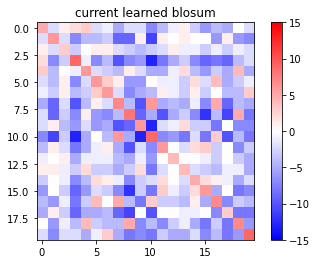

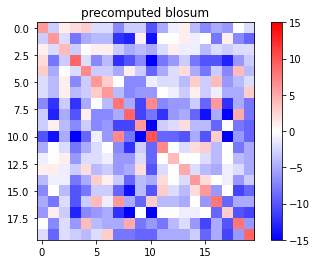

Text(0, 0.5, 'precomputed blosum')

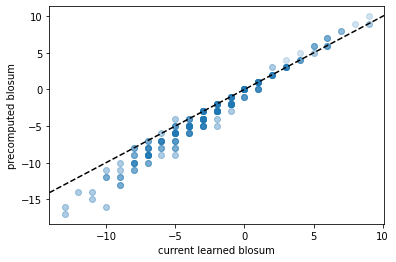

In [106]:
plt.imshow(blosum_3di, vmin = -15, vmax =15, cmap = 'bwr')
plt.colorbar()
plt.title("current learned blosum")
plt.show()
plt.imshow(pc_blosum_3di, vmin = -15, vmax =15, cmap = 'bwr')
plt.colorbar()
plt.title("precomputed blosum")
plt.show()

plt.scatter(blosum_3di.flatten(),pc_blosum_3di.flatten(),alpha = .2)
plt.axline((0, 0), slope=1, color='black', linestyle='--')
plt.xlabel("current learned blosum")
plt.ylabel("precomputed blosum")


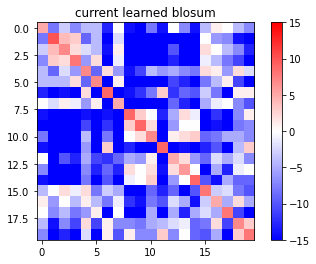

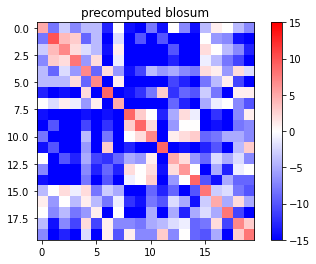

Text(0, 0.5, 'precomputed blosum')

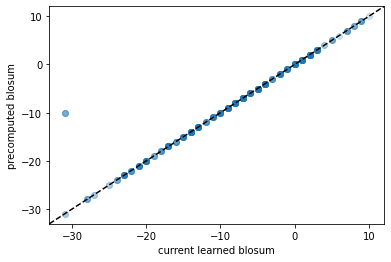

In [107]:
plt.imshow(blosum_mse, vmin = -15, vmax =15, cmap = 'bwr')
plt.colorbar()
plt.title("current learned blosum")
plt.show()
plt.imshow(pc_blosum_mse, vmin = -15, vmax =15, cmap = 'bwr')
plt.colorbar()
plt.title("precomputed blosum")
plt.show()

plt.scatter(blosum_mse.flatten(),pc_blosum_mse.flatten(), alpha = .2)
plt.axline((0, 0), slope=1, color='black', linestyle='--')
plt.xlabel("current learned blosum")
plt.ylabel("precomputed blosum")
